In [1]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
import keras
import keras.models as models

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import BatchNormalization,Input, Cropping2D 

from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.convolutional import Convolution2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Model
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from random import shuffle
from PIL import Image

Using TensorFlow backend.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
import csv
images = []
angles = []
samples = []
with open('data/driving_log.csv') as csvfile:
    i = 0 
    reader = csv.reader(csvfile)
    for line in reader:
        if i==0: 
            i+=1
            continue
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    i = 0
    correction = 0.25
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name_center = 'data/IMG/'+batch_sample[0].split('/')[-1].strip()
                name_left   = 'data/IMG/'+batch_sample[1].split('/')[-1].strip()
                name_right  = 'data/IMG/'+batch_sample[2].split('/')[-1].strip()
                
                center_image = np.asarray(Image.open(name_center))
                left_image   = np.asarray(Image.open(name_left))
                right_image  = np.asarray(Image.open(name_right))
                
                steering_center = float(batch_sample[3])
                steering_left = steering_center + correction
                steering_right = steering_center - correction

                images.append(center_image)
                images.append(left_image)
                images.append(right_image)
                
                angles.append(steering_center)
                angles.append(steering_left)
                angles.append(steering_right)
                
                #images.extend([center_image, left_image, right_image])
                #angles.extend([steering_center, steering_left, steering_right])

                img_center_flipped = np.fliplr(center_image)
                img_left_flipped   = np.fliplr(left_image)
                img_right_flipped  = np.fliplr(right_image)

                #images.extend([img_center_flipped, img_left_flipped, img_right_flipped])
                #angles.extend([[-steering_center, -steering_left, -steering_right]])
                
                images.append(img_center_flipped)
                images.append(img_left_flipped)
                images.append(img_right_flipped)
                
                angles.append(-steering_center)
                angles.append(-steering_left)
                angles.append(-steering_right)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

print ('OK')

OK


In [3]:

ch, row, col = 3, 160, 320  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=(row, col, ch),output_shape=(row, col, ch)))
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))

#########################################################
model.add(Convolution2D(24,5,5,border_mode='valid', W_regularizer=l2(0.001), subsample=(2,2)))
model.add(ELU())
model.add(Convolution2D(36,5,5,border_mode='valid',  W_regularizer=l2(0.001), subsample=(2,2)))
model.add(ELU())
model.add(Convolution2D(48,5,5,border_mode='valid',  W_regularizer=l2(0.001), subsample=(2,2)))
model.add(ELU())
model.add(Convolution2D(64,3,3,border_mode='valid',  W_regularizer=l2(0.001), subsample=(1,1)))
model.add(ELU())
model.add(Convolution2D(64,3,3,border_mode='valid',  W_regularizer=l2(0.001), subsample=(1,1)))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Flatten())
#model.add(Dense(1164, activation='relu'))
#model.add(ELU())
#model.add(Dropout(0.5))
model.add(Dense(100,  W_regularizer=l2(0.001)))
model.add(ELU())
#model.add(Dropout(0.5))
model.add(Dense(50,  W_regularizer=l2(0.001)))
model.add(ELU())
model.add(Dense(10,  W_regularizer=l2(0.001)))
model.add(ELU())
model.add(Dense(1))
#########################################################
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= 
            len(train_samples), validation_data=validation_generator, 
            nb_val_samples=len(validation_samples), nb_epoch=25)

Epoch 1/25
6336/6428 [============================>.] - ETA: 0s - loss: 0.7537

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6528/6428 [==============================] - 22s - loss: 0.7468 - val_loss: 0.5180
Epoch 2/25
6528/6428 [==============================] - 16s - loss: 0.5065 - val_loss: 0.4930
Epoch 3/25
6528/6428 [==============================] - 17s - loss: 0.4807 - val_loss: 0.4662
Epoch 4/25
6528/6428 [==============================] - 17s - loss: 0.4556 - val_loss: 0.4415
Epoch 5/25
6528/6428 [==============================] - 17s - loss: 0.4358 - val_loss: 0.4198
Epoch 6/25
6504/6428 [==============================] - 17s - loss: 0.4142 - val_loss: 0.4027
Epoch 7/25
6528/6428 [==============================] - 16s - loss: 0.3887 - val_loss: 0.3757
Epoch 8/25
6528/6428 [==============================] - 16s - loss: 0.3712 - val_loss: 0.3590
Epoch 9/25
6528/6428 [==============================] - 16s - loss: 0.3559 - val_loss: 0.3444
Epoch 10/25
6528/6428 [==============================] - 16s - loss: 0.3375 - val_loss: 0.3247
Epoch 11/25
6528/6428 [==============================] - 16s - loss: 0

In [4]:
model.save('model_epoch_25.h5')
print('Model Saved!')

Model Saved!


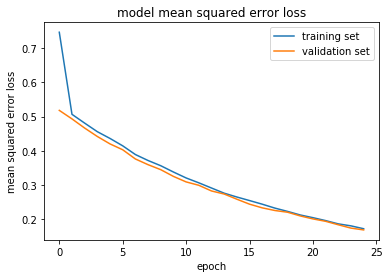

In [5]:

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()